# Plot Cluster DMGs

In [1]:
import pandas as pd
import anndata
import matplotlib.pyplot as plt

from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
adata_path = '../step_by_step/100kb/adata.with_coords.h5ad'
cluster_col = 'L1'

downsample = 30000

mc_type = 'CHN'
coord_base = 'tsne'

cluster_dmg_path = 'L1.OneVsRestDMG.hdf'

## Load

### Clustering results

In [3]:
adata = anndata.read_h5ad(adata_path)

# downsample cells when plot - to use less memory
if downsample and (adata.n_obs > downsample):
    use_cells = adata.obs.sample(downsample, random_state=0).index
    adata = adata[adata.obs_names.isin(use_cells), :].copy()
else:
    use_cells = adata.obs_names

## Cluster DMGs

In [4]:
cluster_dmgs = pd.read_hdf(cluster_dmg_path)
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000058325.6,1.010831e-176,0.517204,0.968014,c17
ENSMUSG00000106379.1,8.695325e-176,0.503299,0.966699,c17
ENSMUSG00000057315.14,2.695185e-175,0.559191,0.965909,c17
ENSMUSG00000048410.17,2.788084e-175,0.520144,0.965830,c17
ENSMUSG00000052613.16,1.398256e-171,0.620752,0.960779,c17


## Gene mC Fraction Data

In [8]:
gene_meta = pd.read_csv(f'GeneMetadata.csv.gz', index_col=0)
gene_name_to_gene_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_meta.index.name = 'gene_id'

gene_frac_da = MCDS.open(f'geneslop2k_frac.mcds',
                         use_obs=use_cells)[f'geneslop2k_da_frac']
gene_frac_da = gene_frac_da.sel(mc_type=mc_type).load()
gene_frac_da

<xarray.DataArray 'geneslop2k_da_frac' (cell: 16985, geneslop2k: 41871)>
array([[1.6991671 , 1.7433007 , 0.71863145, ..., 1.        , 0.69835645,
        1.        ],
       [0.65472096, 0.5947372 , 0.5717225 , ..., 1.        , 0.4346478 ,
        1.        ],
       [0.5538888 , 0.63673854, 0.5269188 , ..., 0.5246332 , 0.3255351 ,
        1.        ],
       ...,
       [1.6366575 , 0.6676105 , 1.066267  , ..., 0.6373466 , 0.64334995,
        1.        ],
       [2.9038475 , 2.7457557 , 1.4736292 , ..., 1.        , 0.6865643 ,
        1.        ],
       [0.5406686 , 0.37049064, 0.9384939 , ..., 1.        , 1.6833304 ,
        1.        ]], dtype=float32)
Coordinates:
  * cell                 (cell) <U10 '10E_M_207' '10E_M_338' ... '9J_M_2969'
  * geneslop2k           (geneslop2k) <U21 'ENSMUSG00000102693.1' ... 'ENSMUS...
    geneslop2k_chrom     (geneslop2k) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY'
    geneslop2k_cov_mean  (geneslop2k) float64 74.71 58.61 ... 1.367e+03 0.1074
    geneslop2k_end       (geneslop2k) int64 3076321 3104124 ... 90846039
    geneslop2k_start     (geneslop2k) int64 3071252 3100015 ... 90835412
    mc_type              <U3 'CHN'
    strand_type          <U4 'both'

## Plot

In [13]:
def get_gene_values_by_name(gene_name):
    data = gene_frac_da.sel(geneslop2k=gene_name_to_gene_id[gene_name]).to_pandas()
    data.name = gene_name
    return data

### Plot Single Gene

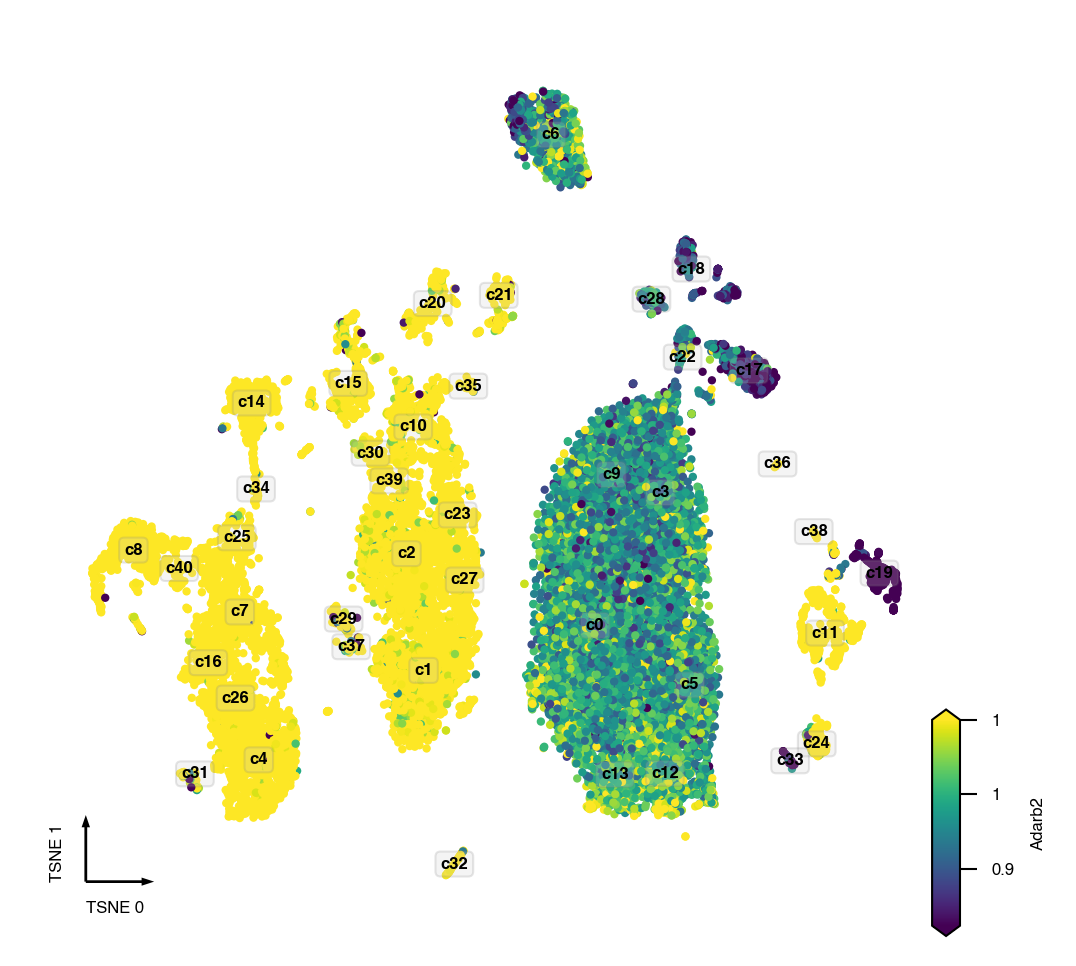

In [14]:
gene = 'Adarb2'
hue_norm = (0.67, 1.5)
coord_base = 'tsne'

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

_ = continuous_scatter(ax=ax,
                       data=adata.obs,
                       hue=get_gene_values_by_name(gene),
                       hue_norm=hue_norm,
                       text_anno=cluster_col,
                       coord_base=coord_base,
                       max_points=None,
                       s=4)

### Plot Cluster Top Markers

In [19]:
def plot_cluster_and_genes(cluster, cell_meta, cluster_col, genes_data,
                           coord_base='umap', ncols=5, axes_size=3, dpi=150, hue_norm=(0.67, 1.5)):
    ncols = max(2, ncols)
    nrows = 1 + (genes_data.shape[1] - 1) // ncols + 1

    # figure
    fig = plt.figure(figsize=(ncols * axes_size, nrows * axes_size), dpi=dpi)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    # cluster axes
    ax = fig.add_subplot(gs[0, 0])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        axis_format=None,
                        hue=cluster_col,
                        palette='tab20')
    ax.set_title('All Clusters')
    ax = fig.add_subplot(gs[0, 1])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        hue=cell_meta[cluster_col] == cluster,
                        axis_format=None,
                        palette={
                            True: 'red',
                            False: 'lightgray'
                        })
    ax.set_title('This Cluster')

    # gene axes
    for i, (gene, data) in enumerate(genes_data.iteritems()):
        col = i % ncols
        row = i // ncols + 1
        ax = fig.add_subplot(gs[row, col])

        if ax.get_subplotspec().is_first_col() and ax.get_subplotspec().is_last_row():
            axis = 'tiny'
        else:
            axis = None

        continuous_scatter(ax=ax,
                           data=cell_meta,
                           hue=data,
                           axis_format=axis,
                           hue_norm=hue_norm,
                           coord_base=coord_base)
        ax.set_title(f'{data.name}')
    fig.suptitle(f'Cluster {cluster} Top Markers')
    return fig

### Per Cluster Plots

In [16]:
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000058325.6,1.010831e-176,0.517204,0.968014,c17
ENSMUSG00000106379.1,8.695325e-176,0.503299,0.966699,c17
ENSMUSG00000057315.14,2.695185e-175,0.559191,0.965909,c17
ENSMUSG00000048410.17,2.788084e-175,0.520144,0.965830,c17
ENSMUSG00000052613.16,1.398256e-171,0.620752,0.960779,c17


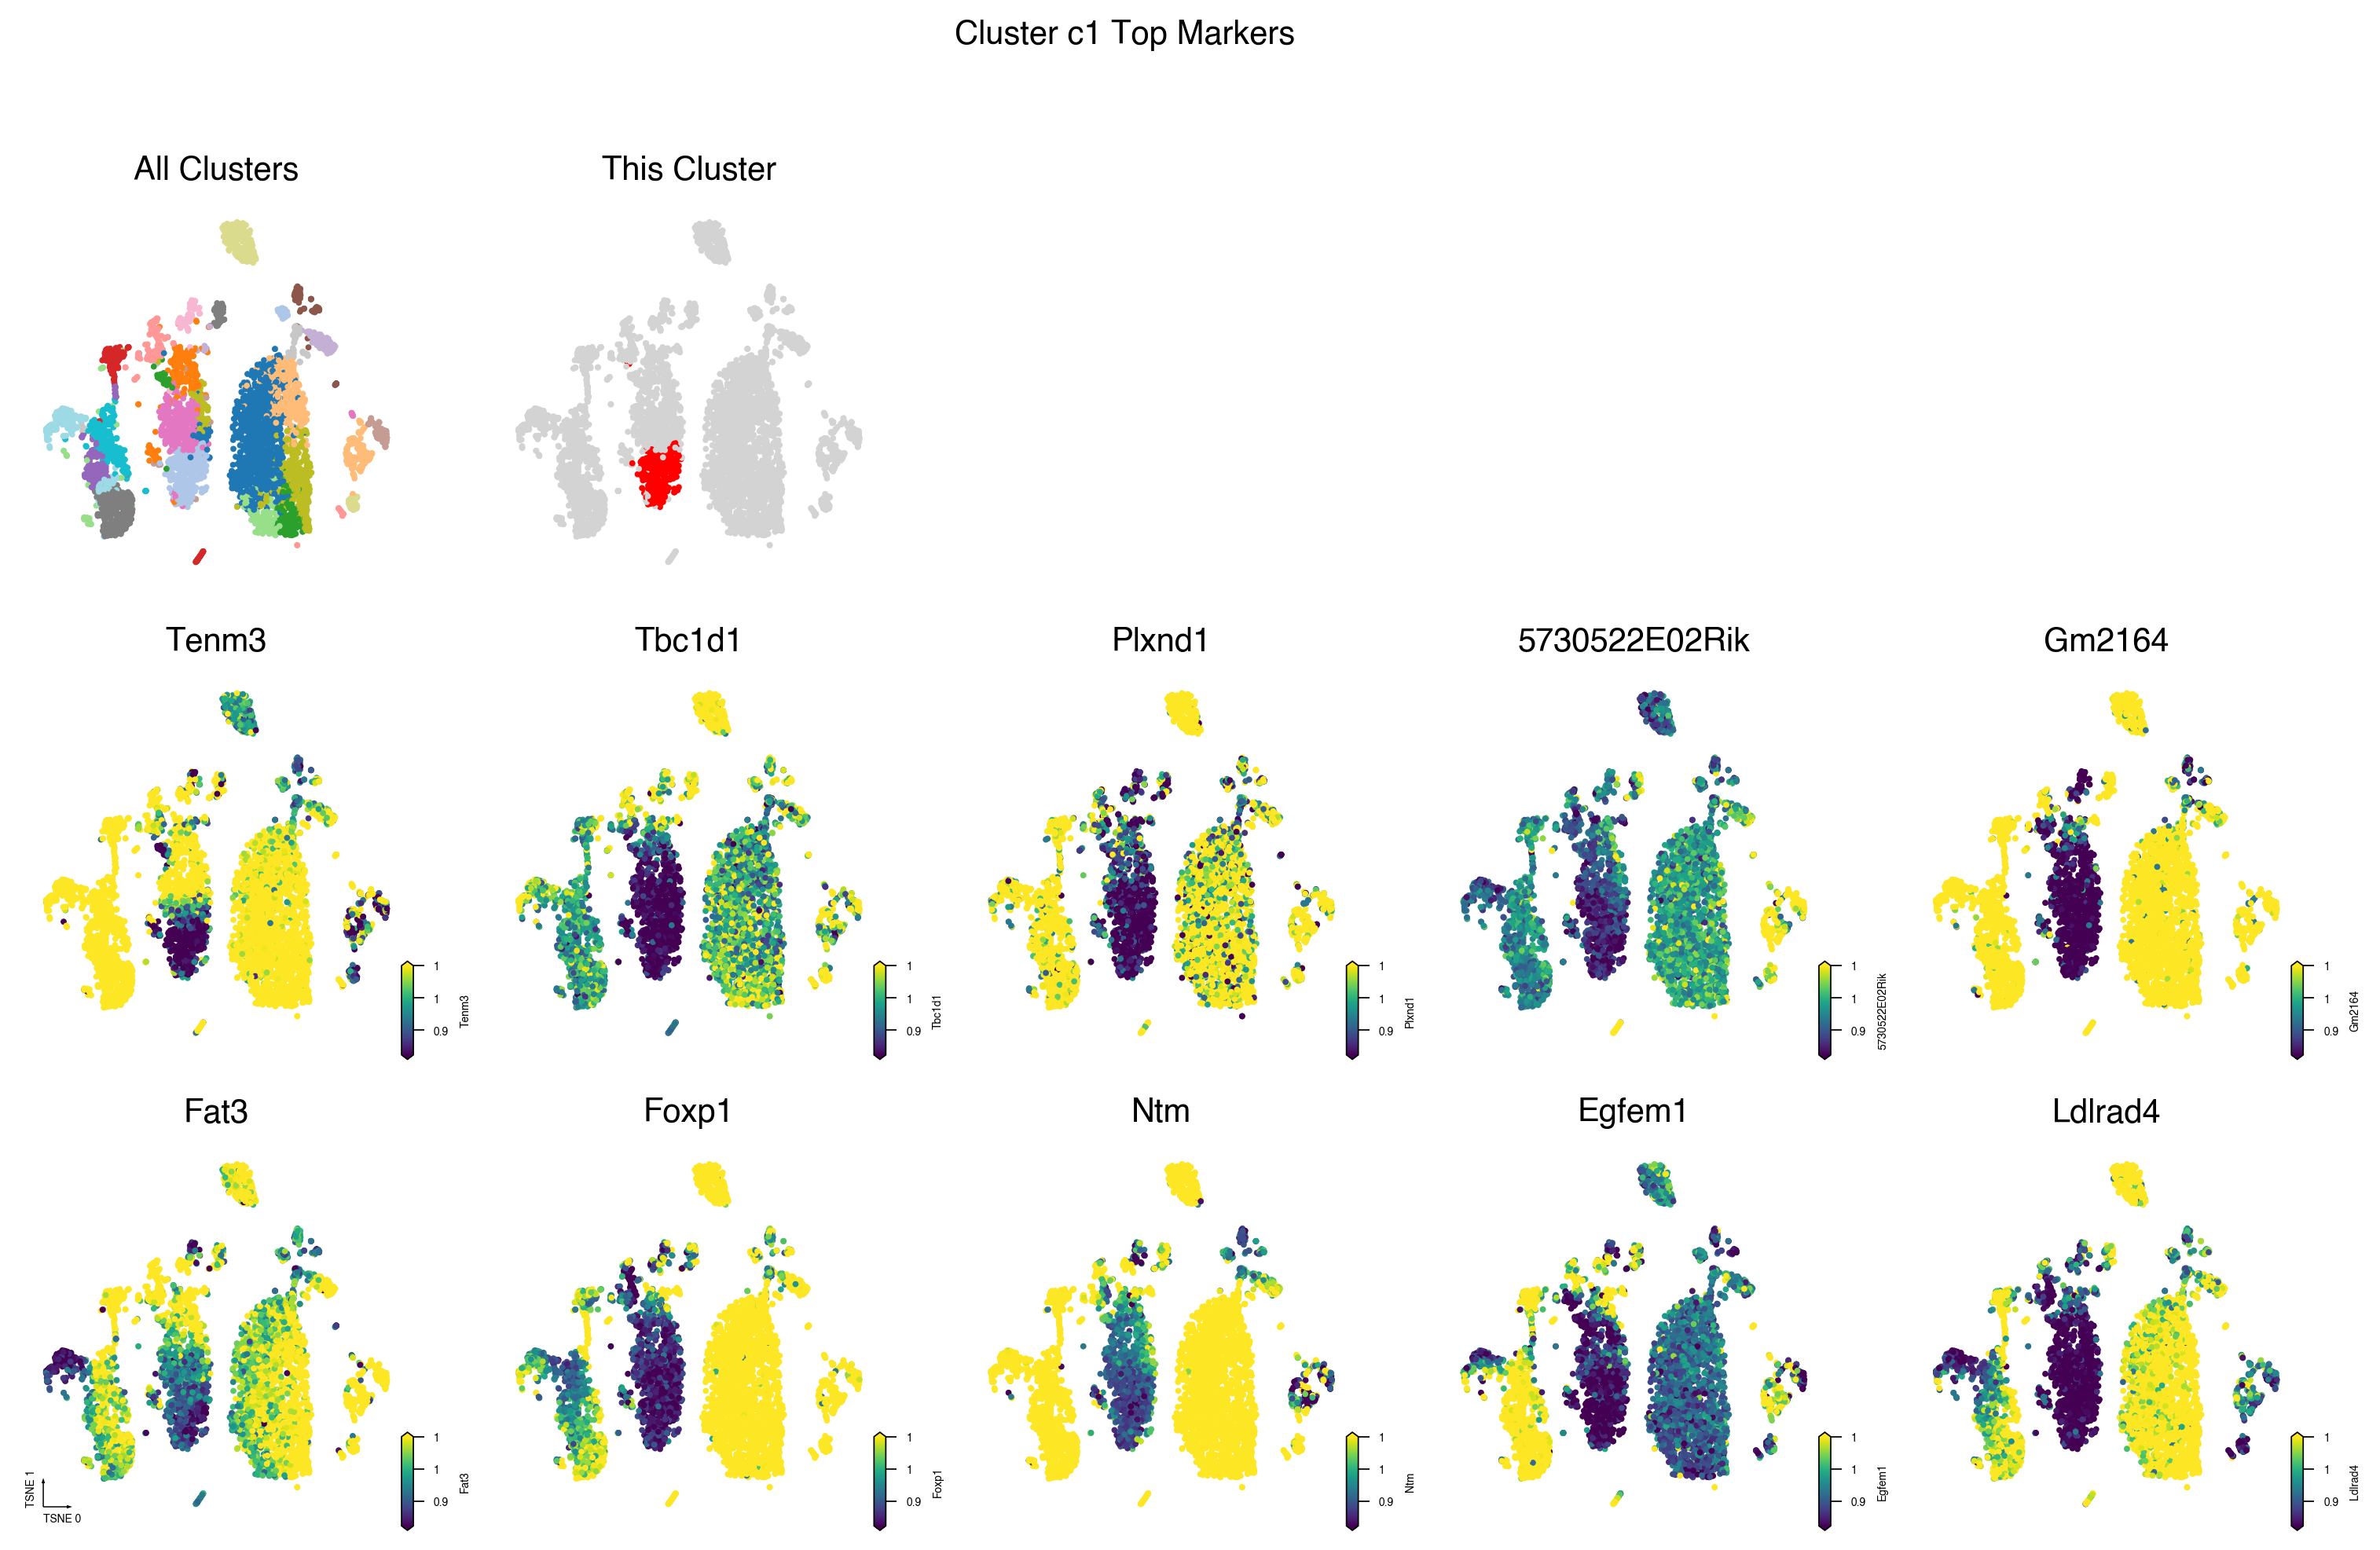

In [20]:
cluster = 'c1'
genes = cluster_dmgs[cluster_dmgs['cluster'] == cluster].sort_values(
    'AUROC', ascending=False)[:10]
genes_data = gene_frac_da.sel(geneslop2k=genes.index).to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])

fig = plot_cluster_and_genes(cluster=cluster,
                             cell_meta=adata.obs,
                             cluster_col=cluster_col,
                             genes_data=genes_data,
                             coord_base='tsne',
                             ncols=5,
                             axes_size=3,
                             dpi=250,
                             hue_norm=(0.67, 1.5))

fig.savefig(f'{cluster}.TopMarker.png', bbox_inches='tight')